In [1]:
import torch
from load_data import *

In [2]:
device = torch.device('cuda:0')

# Load Dataset
- load_adult_data
- load_german_data
- load_bank_data
- load_compas_data

In [27]:
Xtr, Xte, ytr, yte, Ztr, Zte = load_german_data()
ytr = ytr.astype('float32').reshape((-1,1))
yte = yte.astype('float32').reshape((-1,1))

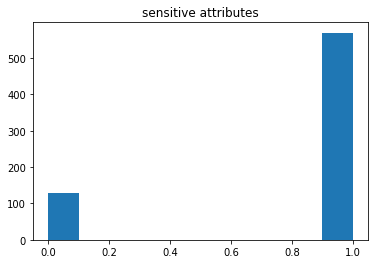

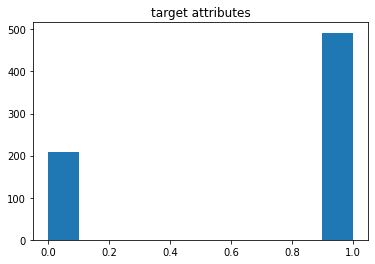

In [28]:
import matplotlib.pyplot as plt
plt.hist(Ztr[:,0])
plt.title("sensitive attributes")
plt.show()
plt.hist(ytr)
plt.title("target attributes")
plt.show()

In [29]:
zy = Ztr + 2*ytr

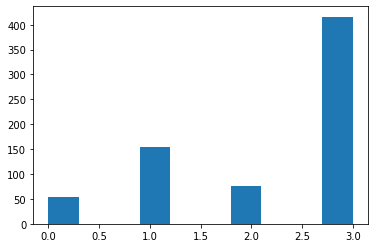

In [30]:
plt.hist(zy[:,0])
plt.show()

- 위의 Graph 를 보면, z 와 y 의 correlation 이 굉장히 높음을 확인할 수 있음

In [31]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training default: ", sum(ytr==0)/len(ytr))
print("test default: ", sum(yte==0)/len(yte))

sensitive ratio:  [0.18571429]
training default:  [0.29714286]
test default:  [0.30666667]


In [32]:
print('# training samples:', Xtr.shape)
print('# test samples:', Xte.shape)
print('# sensitive vars', Ztr.shape)
print('# output vars', ytr.shape)

# training samples: (700, 23)
# test samples: (300, 23)
# sensitive vars (700, 1)
# output vars (700, 1)


In [33]:
N1 = 200
Xtr1 = Xtr[:N1]
ytr1 = ytr[:N1]
Ztr1 = Ztr[:N1]
Xtr2 = Xtr[N1:]
ytr2 = ytr[N1:]
Ztr2 = Ztr[N1:]

In [34]:
nn = np.unique(Xtr1,axis=0)
print(nn[0])
print(len(np.unique(Xtr1,axis=0)))
print(len(np.unique(Xtr,axis=0)))
print(Xtr.shape)


[0.         0.02941176 0.5        0.02739726 0.         0.25
 0.66666667 1.         0.         1.         0.         1.
 1.         0.         1.         0.         1.         0.
 0.         1.         0.         1.         0.        ]
200
700
(700, 23)


In [35]:
repeated_idx = np.argwhere(np.all(Xtr==nn[0],axis=1))

In [36]:
print(repeated_idx.flatten())

[134]


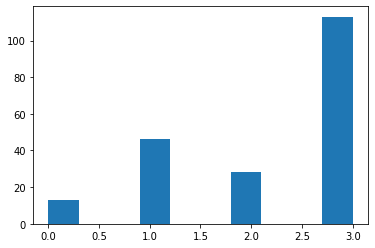

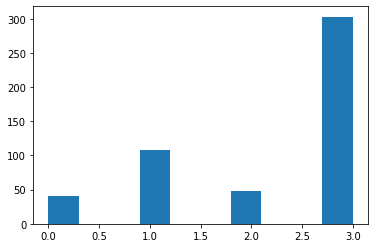

In [37]:
zy1 = Ztr1 + 2*ytr1
plt.hist(zy1[:,0])
plt.show()
zy2 = Ztr2 + 2*ytr2
plt.hist(zy2[:,0])
plt.show()

In [14]:
np.unique(Ztr)

array([0., 1.])

In [15]:
Ztr.shape

(31655, 1)

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [17]:
from fairNN_train import *
from load_data import *

In [38]:
class Args:
    def __init__(self):
        self.epochs = 30
#         self.max_epochs = None
        self.AL_iters = 10 # AL batch 몇 번 뽑는지?
        self.AL_batch = 32 # AL 시에 select 되는 데이터 수
        self.batch_size = 32
        self.AL_select = 'acc'
#         self.AL_valid = 32
        
    def print_args(self):
        print("train epochs/batch: {}/{}".format(self.epochs,self.batch_size))
        print("AL iters/batch: {}/{}".format(self.AL_iters,self.AL_batch))
        print("AL selection is based on ", self.AL_select)

In [39]:
args = Args()

In [40]:
train_data = NPsDataSet(Xtr1, ytr1, Ztr1)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=True)

In [41]:
from fair_eval import *

In [42]:
zZtr2 = transform_dum2cat(Ztr2)
select_data = NPsDataSet(Xtr2, ytr2, zZtr2)
select_loader = DataLoader(select_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [43]:
test_data = NPsDataSet(Xte, yte, Zte)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

- gradient calculation for unlabeled set
- expectation 
- https://discuss.pytorch.org/t/how-to-efficiently-compute-gradient-for-each-training-sample/60001/2 
- https://github.com/cybertronai/autograd-hacks#per-example-gradients 
- https://tutorials.pytorch.kr/intermediate/tensorboard_tutorial.html

# Group Selection Part

## Test Group Performance

## find examples for the worst group

In [44]:
from fairAL_utils import *

## retraining models

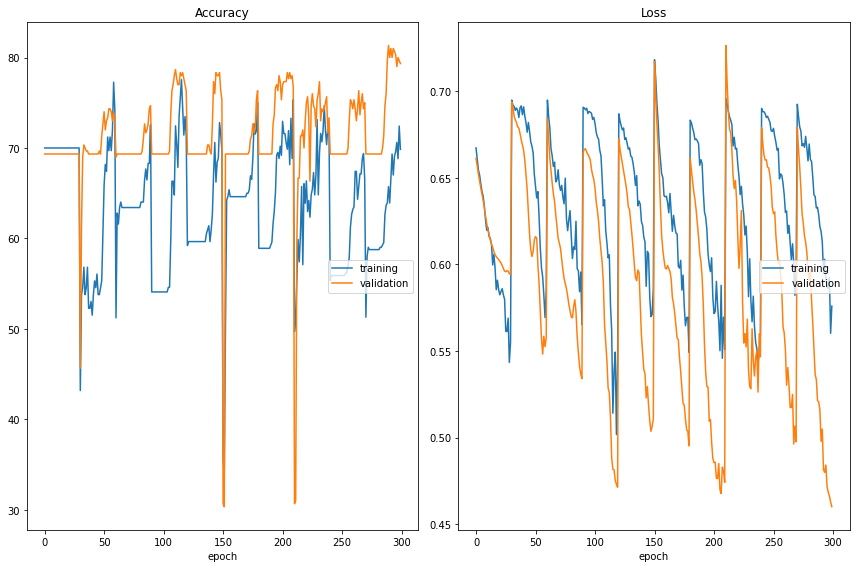

Accuracy
	training         	 (min:   34.231, max:   77.551, cur:   69.845)
	validation       	 (min:   30.333, max:   81.333, cur:   79.333)
Loss
	training         	 (min:    0.502, max:    0.718, cur:    0.576)
	validation       	 (min:    0.460, max:    0.726, cur:    0.460)
Finished Training
0.0 : loss 0.5018123984336853 / acc 76.9230728149414
1.0 : loss 0.45954766869544983 / acc 79.31034851074219


In [45]:
clf,f_train,f_select = train_AL_valid(train_loader, select_loader, device, args, test_loader, \
                                      from_scratch = True, random_sel = False,val_ratio = 0.5)

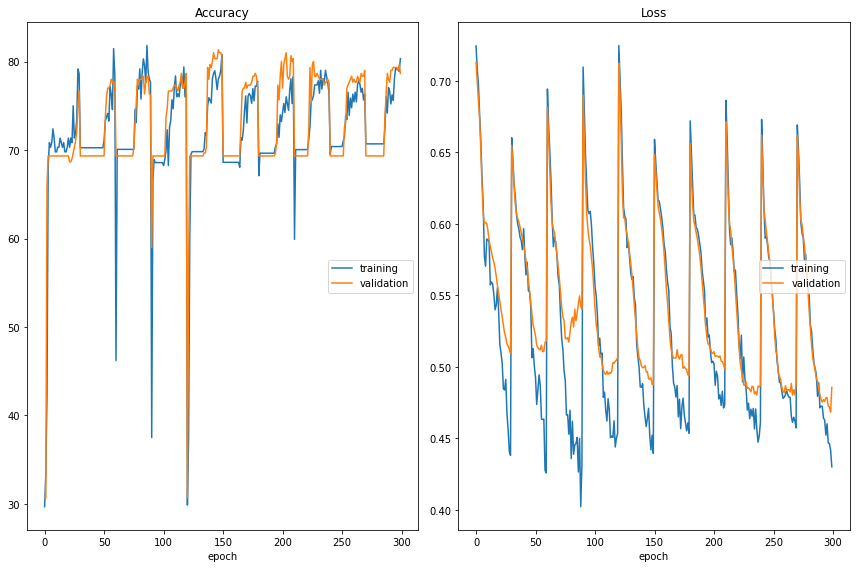

Accuracy
	training         	 (min:   29.688, max:   81.818, cur:   80.328)
	validation       	 (min:   30.667, max:   81.333, cur:   78.667)
Loss
	training         	 (min:    0.402, max:    0.725, cur:    0.430)
	validation       	 (min:    0.468, max:    0.713, cur:    0.486)
Finished Training
0.0 : loss 0.49045616388320923 / acc 78.35051727294922
1.0 : loss 0.40976348519325256 / acc 80.3069076538086


In [46]:
clf2,_,_ = train_AL(train_loader, select_loader, device, args, test_loader, from_scratch = True, random_sel = True)

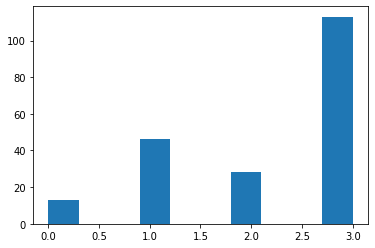

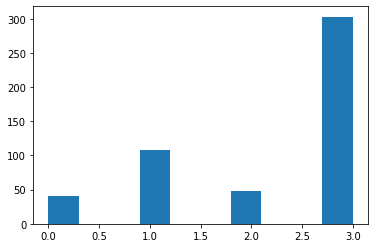

In [47]:
zy1 = train_loader.dataset.tensors[2] + 2*train_loader.dataset.tensors[1]
plt.hist(zy1[:,0])
plt.show()
zy2 = select_loader.dataset.tensors[2] + 2*select_loader.dataset.tensors[1]
plt.hist(zy2[:,0])
plt.show()

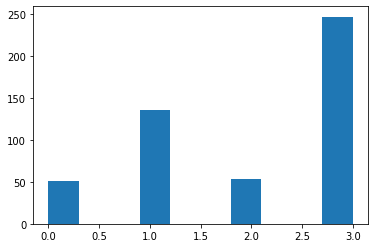

In [48]:
zy3 = f_train.dataset.tensors[2] + 2*f_train.dataset.tensors[1]
plt.hist(zy3[:,0])
plt.show()

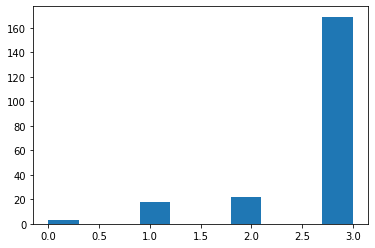

In [49]:
zy3 = f_select.dataset.tensors[2] + 2*f_select.dataset.tensors[1]
plt.hist(zy3[:,0])
plt.show()

In [50]:
clf_criterion = nn.BCELoss()
print("training performances")
test_groupwise(clf,train_loader, clf_criterion, device,args)
print(test_model(clf, train_loader, clf_criterion, device))
print("test performances")
test_groupwise(clf,test_loader, clf_criterion, device,args)
print(test_model(clf, test_loader, clf_criterion, device))
print("select performances")
test_groupwise(clf,select_loader, clf_criterion, device,args)
print(test_model(clf, select_loader, clf_criterion, device))

training performances
0.0 : loss 0.41583213210105896 / acc 87.80487823486328
1.0 : loss 0.4521259069442749 / acc 77.98741912841797
(tensor(0.4445), tensor(79.6875))
test performances
0.0 : loss 0.5283485651016235 / acc 75.0
1.0 : loss 0.44302770495414734 / acc 80.41666412353516
(tensor(0.4601), tensor(79.3333))
select performances
0.0 : loss 0.5924805998802185 / acc 69.66291809082031
1.0 : loss 0.4460248649120331 / acc 78.83211517333984
(tensor(0.4721), tensor(77.2000))


In [51]:
clf_criterion = nn.BCELoss()
print("training performances")
test_groupwise(clf2,train_loader, clf_criterion, device,args)
print(test_model(clf2, train_loader, clf_criterion, device))
print("test performances")
test_groupwise(clf2,test_loader, clf_criterion, device,args)
print(test_model(clf2, test_loader, clf_criterion, device))
print("select performances")
test_groupwise(clf2,select_loader, clf_criterion, device,args)
print(test_model(clf2, select_loader, clf_criterion, device))

training performances
0.0 : loss 0.3784751296043396 / acc 85.36585235595703
1.0 : loss 0.38169723749160767 / acc 81.7610092163086
(tensor(0.3761), tensor(82.8125))
test performances
0.0 : loss 0.5913177132606506 / acc 71.66666412353516
1.0 : loss 0.45919761061668396 / acc 80.41666412353516
(tensor(0.4856), tensor(78.6667))
select performances
0.0 : loss 0.6470354795455933 / acc 68.5393295288086
1.0 : loss 0.5224741697311401 / acc 76.3990249633789
(tensor(0.5446), tensor(75.))


# Inspect Methods

In [26]:
# from fairNN_train import *
epochs = 100
n_features = train_loader.dataset.tensors[0].shape[1]
clf = Classifier(n_features=n_features)
clf.to(device)
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())
print(train_loader.dataset.tensors[0].size(0))

tr_loader, val_loader = train_valid_split(train_loader, train_loader.dataset.tensors[0].size(0),\
                                          val_ratio=0.5,random_seed=5)

print(tr_loader.dataset.tensors[0].size())
print(val_loader.dataset.tensors[0].size())

200
torch.Size([100, 7])
torch.Size([100, 7])


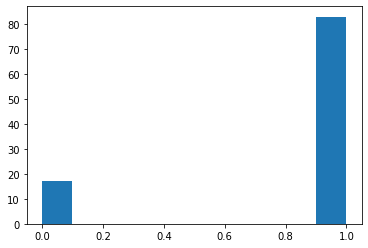

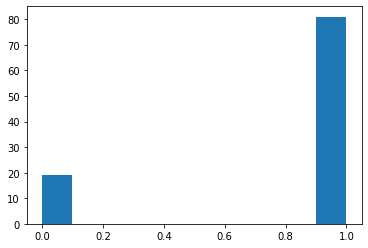

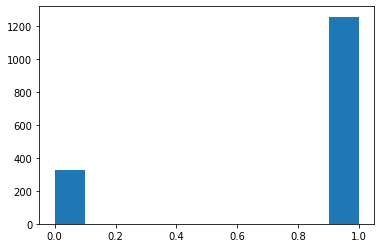

In [27]:
import matplotlib.pyplot as plt
tt = tr_loader.dataset.tensors[2].flatten()# +  tr_loader.dataset.tensors[1].flatten()*2
plt.hist(tt)
plt.show()
ss = val_loader.dataset.tensors[2].flatten() #+  val_loader.dataset.tensors[1].flatten()*2
plt.hist(ss)
plt.show()
uu = test_loader.dataset.tensors[2].flatten() #+  test_loader.dataset.tensors[1].flatten()*2
plt.hist(uu)
plt.show()

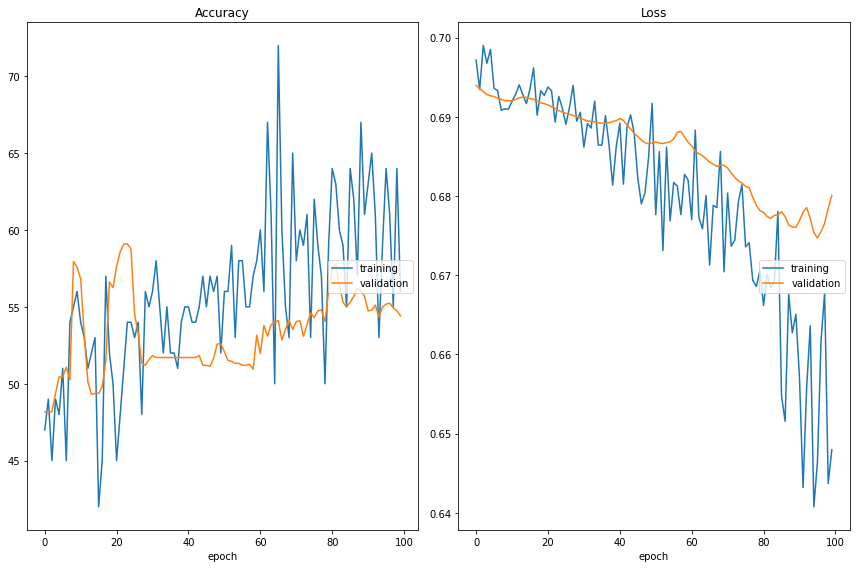

Accuracy
	training         	 (min:   42.000, max:   72.000, cur:   56.000)
	validation       	 (min:   48.169, max:   59.091, cur:   54.419)
Loss
	training         	 (min:    0.641, max:    0.699, cur:    0.648)
	validation       	 (min:    0.675, max:    0.694, cur:    0.680)
Finished Training


In [28]:
train_model(clf, tr_loader, clf_criterion, clf_optimizer, device, 100, test_loader, None)

In [64]:
args.AL_select

'acc'

In [71]:
def test_groupwise(clf, data_loader, clf_criterion, device,args):
    dlTensors = data_loader.dataset.tensors
    dldic = divide_groupsDL(dlTensors[0],dlTensors[1],dlTensors[2])
    losss = 0
    accs = 100.0
    sid = list(dldic.keys())[0]
    for did in dldic.keys():
        loss_v, acc_v = test_model_noz(clf, dldic[did],clf_criterion, device)
        print("{} : loss {} / acc {}".format(did, loss_v, acc_v))
        if args.AL_select == 'loss':
#             print(losss,loss_v,sid,did)
            if losss < loss_v:
                print(sid,did)
                sid = did
                losss = loss_v               
        else:
#             print(did,acc_v,accs)
            assert args.AL_select == 'acc'
#             print(accs > acc_v)
            if accs > acc_v:
#                 print(sid,did)
                sid = did
                accs = acc_v
    return sid, dldic

In [69]:
def cal_meangrad(clf, dataloader, criterion, device,normalize=True):
    
    for i,(x,y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        clf.zero_grad()
        outs = clf(x)
        criterion(outs,y).backward()
        tmp = []
        for param in clf.parameters():
            tmp.append(param.grad.flatten())
        grads_t = torch.cat(tmp)
        if i==0:
            grads = grads_t
        else:
            grads += grads_t
    prgrad_n = torch.norm(grads)
    if normalize:
        grads /= prgrad_n
    grads = grads.detach().cpu()
    return grads

In [30]:
_, _ = test_groupwise(clf, train_loader, clf_criterion, device, args)

0.0 : loss 0.5666709542274475 / acc 69.44444274902344
1.0 : loss 0.6656495928764343 / acc 54.878047943115234


In [31]:
_, _ = test_groupwise(clf, test_loader, clf_criterion, device, args)

0.0 : loss 0.6505141854286194 / acc 60.85626983642578
1.0 : loss 0.6877537965774536 / acc 52.74462890625


In [32]:
sid, dldic = test_groupwise(clf, val_loader, clf_criterion, device, args)
grads = cal_meangrad(clf, dldic[sid], clf_criterion, device,False)
ses,sidx = select_examples(clf, select_loader, clf_criterion, grads,device, args.AL_batch)

0.0 : loss 0.5886512398719788 / acc 63.157894134521484
1.0 : loss 0.664670467376709 / acc 51.85185241699219


In [33]:
grads0 = cal_meangrad(clf, dldic[0], clf_criterion, device,False)
grads1 = cal_meangrad(clf, dldic[1], clf_criterion, device,False)

In [34]:
print(grads0)
print(grads1)
print(torch.matmul(grads0,grads1))
print(torch.matmul(grads0,grads0))
print(torch.matmul(grads1,grads1))
print(sid)

tensor([0.0161, 0.0077, 0.0071,  ..., 0.0000, 0.0000, 0.2086])
tensor([-0.0364,  0.0222,  0.0202,  ...,  0.0000,  0.0000, -0.0073])
tensor(0.0555)
tensor(0.3383)
tensor(0.3315)
1.0


In [83]:
print(torch.matmul(grads0,grads0te))
print(torch.matmul(grads1,grads1te))

tensor(0.0360)
tensor(0.0059)


In [82]:
print(grads0te)
print(grads1te)
print(torch.matmul(grads0te,grads1te))
print(torch.matmul(grads0te,grads0te))
print(torch.matmul(grads1te,grads1te))
print(sid)

tensor([0.0000e+00, 7.5523e-04, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        1.0595e+00])
tensor([ 0.0000,  0.0022,  0.0000,  ...,  0.0000,  0.0000, -0.5502])
tensor(-0.3607)
tensor(1.8582)
tensor(1.2305)
1.0


In [35]:
train_loader2, select_loader2 = obtain_newDS(train_loader, select_loader, ses,sidx,args.batch_size)

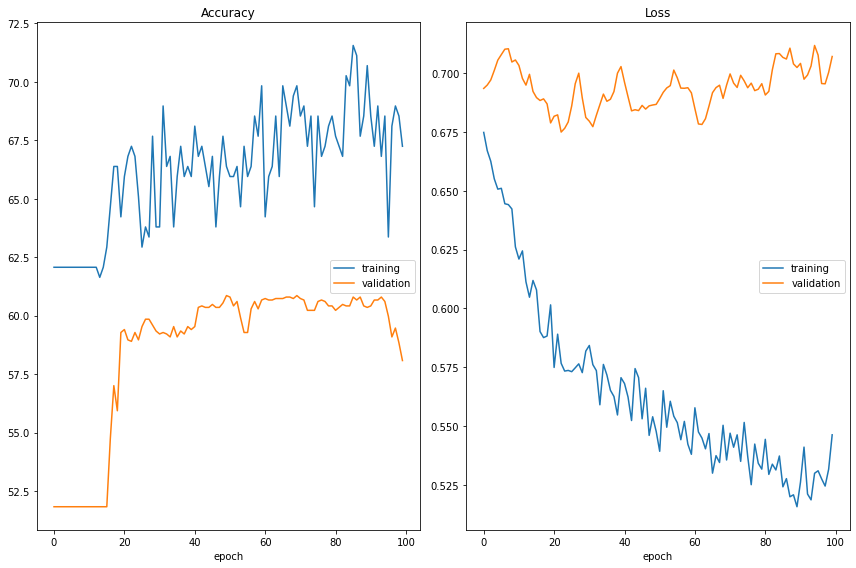

Accuracy
	training         	 (min:   61.638, max:   71.552, cur:   67.241)
	validation       	 (min:   51.831, max:   60.859, cur:   58.081)
Loss
	training         	 (min:    0.516, max:    0.675, cur:    0.546)
	validation       	 (min:    0.675, max:    0.712, cur:    0.707)
Finished Training


In [36]:
clf2 = Classifier(n_features=n_features)
clf2.to(device)
clf_criterion2 = nn.BCELoss()
clf_optimizer2 = optim.Adam(clf2.parameters())
liveloss = PlotLosses()
train_model(clf2, train_loader2, clf_criterion2,clf_optimizer2,device,100, test_loader,liveloss)

In [37]:
sid2, dldic2 = test_groupwise(clf2, test_loader, clf_criterion2, device, args)

0.0 : loss 0.7784196138381958 / acc 64.22018432617188
1.0 : loss 0.688477635383606 / acc 56.48369216918945


In [38]:
_, _ = test_groupwise(clf, test_loader, clf_criterion2, device, args)
_, _ = test_groupwise(clf2, test_loader, clf_criterion2, device, args)

0.0 : loss 0.6505141854286194 / acc 60.85626983642578
1.0 : loss 0.6877537965774536 / acc 52.74462890625
0.0 : loss 0.7784196138381958 / acc 64.22018432617188
1.0 : loss 0.688477635383606 / acc 56.48369216918945


In [39]:
_, _ = test_groupwise(clf, train_loader, clf_criterion2, device, args)
_, _ = test_groupwise(clf2, train_loader2, clf_criterion2, device, args)

0.0 : loss 0.5666709542274475 / acc 69.44444274902344
1.0 : loss 0.6656495928764343 / acc 54.878047943115234
0.0 : loss 0.45424333214759827 / acc 66.66666412353516
1.0 : loss 0.5227502584457397 / acc 69.89795684814453


In [40]:
_, _ = test_groupwise(clf, val_loader, clf_criterion2, device, args)
_, _ = test_groupwise(clf2, val_loader, clf_criterion2, device, args)

0.0 : loss 0.5886512398719788 / acc 63.157894134521484
1.0 : loss 0.664670467376709 / acc 51.85185241699219
0.0 : loss 0.43312814831733704 / acc 73.68421173095703
1.0 : loss 0.5653043985366821 / acc 72.83950805664062


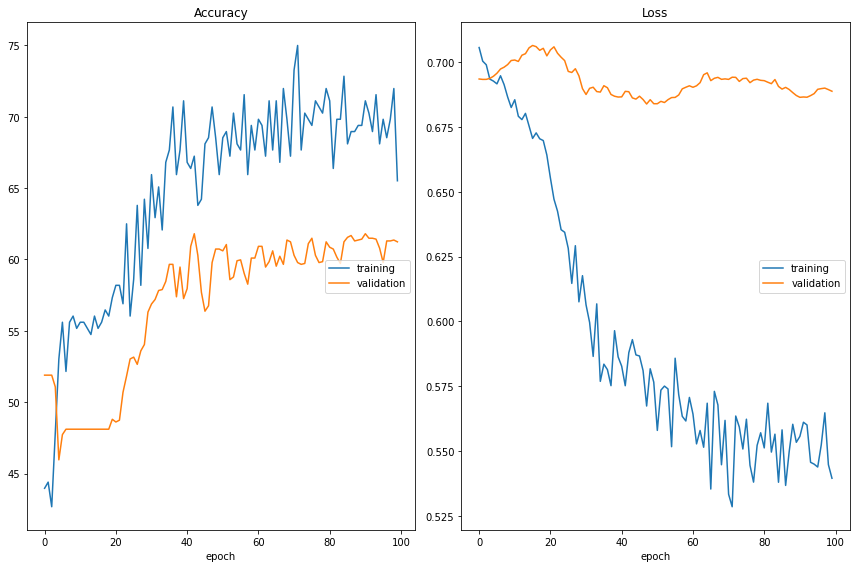

Accuracy
	training         	 (min:   42.672, max:   75.000, cur:   65.517)
	validation       	 (min:   45.960, max:   61.806, cur:   61.237)
Loss
	training         	 (min:    0.528, max:    0.706, cur:    0.539)
	validation       	 (min:    0.684, max:    0.706, cur:    0.689)
Finished Training


In [112]:
clf = Classifier(n_features=n_features)
clf.to(device)
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())
liveloss = PlotLosses()
train_model(clf, train_loader2, clf_criterion,clf_optimizer,device,100, test_loader,liveloss)

In [65]:
def select_examples(clf,select_loader,criterion, grad_z, device, nsample = 32):
    aa = torch.topk(compute_gradsim(clf, select_loader, criterion, grad_z, device),nsample)
    ses = []
    for ts in select_loader.dataset.tensors:
        ses.append(ts[aa[1]])
    return ses,aa[1]

In [69]:
aa = torch.topk(compute_gradsim(clf, select_loader, clf_criterion, grads0, device),32)

In [75]:
print(aa[1])

tensor([ 599, 2741, 3164,  550, 1492, 1708, 1583, 3328, 3366, 1684, 1840, 2253,
        1172, 2977, 2392,  406, 2158,  975,  860, 2146, 2460, 2499,  808, 2480,
        1378, 1336,  794,  959, 2350, 2135, 1924, 2105])


In [78]:
print(select_loader.dataset.tensors[0][599])
print(select_loader.dataset.tensors[0][2741])
print(select_loader.dataset.tensors[0][3164])
print(select_loader.dataset.tensors[0][550])
print(select_loader.dataset.tensors[0][1492])

tensor([1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.2432, 1.0000])
tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2162, 0.0000])
tensor([1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.2703, 1.0000])
tensor([1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.1892, 1.0000])
tensor([1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.1892, 1.0000])


In [76]:
select_loader.dataset.tensors[0][aa[1]]

tensor([[1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.2432, 1.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2162, 0.0000],
        [1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.2703, 1.0000],
        [1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.1892, 1.0000],
        [1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.1892, 1.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1892, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1622, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1622, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1622, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1622, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1622, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1081, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1081, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1081, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1081, 0.0000],
        [1

In [52]:
pred = clf(ses[0].to(device))
pred2 = clf2(ses[0].to(device))

In [46]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [82]:
print(len(np.unique(Xtr2,axis=1)))
print(Xtr2.shape)

3494
(3494, 7)


In [55]:
ses[0]

tensor([[0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0270, 1.0000],
        [0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0270, 1.0000],
        [0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0270, 1.0000],
        [0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0270, 1.0000],
        [0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0270, 1.0000],
        [0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0270, 1.0000],
        [0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0270, 1.0000],
        [0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0270, 1.0000],
        [0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0270, 1.0000],
        [0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0270, 1.0000],
        [0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0270, 1.0000],
        [0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0270, 1.0000],
        [0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0270, 1.0000],
        [0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0270, 1.0000],
        [0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0270, 1.0000],
        [0

In [53]:
pred.flatten()

tensor([0.3632, 0.3632, 0.3632, 0.3632, 0.3632, 0.3632, 0.3632, 0.3632, 0.3632,
        0.3632, 0.3632, 0.3632, 0.3632, 0.3632, 0.3632, 0.3632, 0.3632, 0.3632,
        0.3632, 0.3632, 0.3957, 0.3957, 0.3957, 0.3957, 0.3957, 0.3523, 0.3523,
        0.3523, 0.3523, 0.3523, 0.3523, 0.3523], device='cuda:1',
       grad_fn=<ViewBackward>)

In [54]:
pred2.flatten()

tensor([0.0113, 0.0113, 0.0113, 0.0113, 0.0113, 0.0113, 0.0113, 0.0113, 0.0113,
        0.0113, 0.0113, 0.0113, 0.0113, 0.0113, 0.0113, 0.0113, 0.0113, 0.0113,
        0.0113, 0.0113, 0.0252, 0.0252, 0.0252, 0.0252, 0.0252, 0.0092, 0.0092,
        0.0092, 0.0092, 0.0092, 0.0092, 0.0092], device='cuda:1',
       grad_fn=<ViewBackward>)

In [47]:
confusion_matrix(ses[1][:,0],(pred>0.5).float().detach().cpu().numpy()[:,0])

array([[32]])

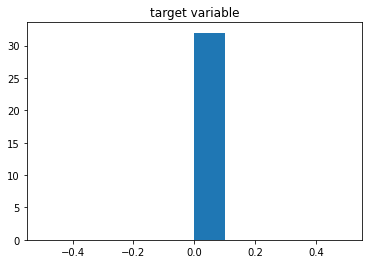

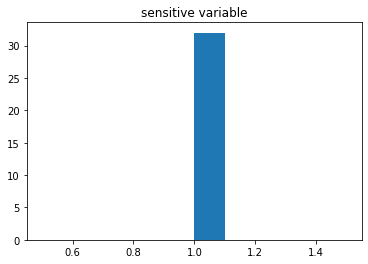

In [48]:
plt.title("target variable")
plt.hist(ses[1][:,0])
plt.show()
plt.title("sensitive variable")
plt.hist(ses[2][:,0])
plt.show()

torch.Size([32, 1])